## 1. Import Libraries và Configuration

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import AdamW
from sklearn.metrics import classification_report, confusion_matrix

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

# Set seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

2025-12-25 13:39:35.025105: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766669975.221327      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766669975.277817      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766669975.739288      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766669975.739325      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766669975.739328      24 computation_placer.cc:177] computation placer alr

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# For Kaggle
BASE_DIR = '/kaggle/input/bean-leaf-lesions-classification'

# For Local - uncomment below
# BASE_DIR = r'D:\DataMining\DoAn02'

CONFIG = {
    'BASE_DIR': BASE_DIR,
    'TRAIN_DIR': os.path.join(BASE_DIR, 'train'),
    'VAL_DIR': os.path.join(BASE_DIR, 'val'),
    'TRAIN_CSV': os.path.join(BASE_DIR, 'train.csv'),
    'VAL_CSV': os.path.join(BASE_DIR, 'val.csv'),
    'CLASSNAME_FILE': os.path.join(BASE_DIR, 'classname.txt'),
    'IMG_SIZE': 224,
    'BATCH_SIZE': 32,
    'PHASE1_EPOCHS': 50,
    'PHASE2_EPOCHS': 60,
    'PHASE1_LR': 5e-4,
    'PHASE2_LR': 1e-5,
    'SEED': 42,
    'NUM_CLASSES': 3,
}

# Load class names
with open(CONFIG['CLASSNAME_FILE'], 'r') as f:
    CLASS_NAMES = [line.strip() for line in f.readlines()]
NUM_CLASSES = len(CLASS_NAMES)
CONFIG['NUM_CLASSES'] = NUM_CLASSES

print(f"Base Directory: {BASE_DIR}")
print(f"Image Size: {CONFIG['IMG_SIZE']}x{CONFIG['IMG_SIZE']}")
print(f"Batch Size: {CONFIG['BATCH_SIZE']}")
print(f"Phase 1 LR: {CONFIG['PHASE1_LR']}")
print(f"Phase 2 LR: {CONFIG['PHASE2_LR']}")
print(f"Class Names: {CLASS_NAMES}")
print(f"Number of Classes: {NUM_CLASSES}")

Base Directory: /kaggle/input/bean-leaf-lesions-classification
Image Size: 224x224
Batch Size: 32
Phase 1 LR: 0.0005
Phase 2 LR: 1e-05
Class Names: ['healthy', 'angular_leaf_spot', 'bean_rust']
Number of Classes: 3


## 2. Data Loading

Đọc 2 file CSV chứa thông tin về tập train (1034 mẫu) và validation (133 mẫu), tổng cộng 1167 ảnh lá đậu.

Với 133 mẫu validation, target đặt ra là chỉ được phân loại sai tối đa 1 sample, tương đương độ chính xác 99.25%.

Dataset có 3 class (healthy, angular_leaf_spot, bean_rust) với tỷ lệ gần như cân bằng 

In [3]:
train_df = pd.read_csv(CONFIG['TRAIN_CSV'])
val_df = pd.read_csv(CONFIG['VAL_CSV'])

print("Dataset Statistics:")
print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Total: {len(train_df) + len(val_df)}")
print(f"\nTarget: {len(val_df) - 1}/{len(val_df)} correct = {(len(val_df)-1)/len(val_df)*100:.2f}% accuracy")

# Class distribution
class_counts = train_df['category'].value_counts().sort_index()
for i, count in enumerate(class_counts):
    print(f"   {i}: {CLASS_NAMES[i]} - {count} samples ({count/len(train_df)*100:.1f}%)")

Dataset Statistics:
Train samples: 1034
Validation samples: 133
Total: 1167

Target: 132/133 correct = 99.25% accuracy
   0: healthy - 341 samples (33.0%)
   1: angular_leaf_spot - 345 samples (33.4%)
   2: bean_rust - 348 samples (33.7%)



TẠO ĐƯỜNG DẪN ĐẦY ĐỦ (path_full)

Chuyển đổi nhãn vì ImageDataGenerator yêu cầu y_col là string cho class_mode='categorical'

Kiểm tra file tồn tại

In [4]:
# Create full paths
train_df['path_full'] = train_df['image:FILE'].apply(lambda x: os.path.join(BASE_DIR, x))
val_df['path_full'] = val_df['image:FILE'].apply(lambda x: os.path.join(BASE_DIR, x))

# Convert category to string
train_df['category_str'] = train_df['category'].astype(str)
val_df['category_str'] = val_df['category'].astype(str)

# Verify paths
train_df['exists'] = train_df['path_full'].apply(os.path.exists)
val_df['exists'] = val_df['path_full'].apply(os.path.exists)

print(f"Train - Valid paths: {train_df['exists'].sum()}/{len(train_df)}")
print(f"Val - Valid paths: {val_df['exists'].sum()}/{len(val_df)}")

Train - Valid paths: 1034/1034
Val - Valid paths: 133/133


## 3. Data Generators với Disease-Aware Augmentation

Data Generators với Disease-Aware Augmentation:
- Train: Augmentation nhẹ (rotation 10°, shift 5%, zoom 5%, flip, brightness ±10%)
  -> Bảo toàn đặc trưng bệnh lá (đốm, màu, texture) trong khi tăng đa dạng dữ liệu
- Validation: Chỉ rescale, không augmentation, shuffle=False
- Output: 1034 train + 133 val samples, 3 classes, batch_size=32, img_size=224x224

In [5]:
# Training - Conservative augmentation to preserve disease features
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.9, 1.1],
    fill_mode='reflect'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path_full',
    y_col='category_str',
    target_size=(CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']),
    batch_size=CONFIG['BATCH_SIZE'],
    class_mode='categorical',
    shuffle=True,
    seed=CONFIG['SEED']
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='path_full',
    y_col='category_str',
    target_size=(CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']),
    batch_size=CONFIG['BATCH_SIZE'],
    class_mode='categorical',
    shuffle=False
)

print(f"Train: {train_generator.samples} samples")
print(f"Val: {val_generator.samples} samples")
print(f"Class indices: {train_generator.class_indices}")

Found 1034 validated image filenames belonging to 3 classes.
Found 133 validated image filenames belonging to 3 classes.
Train: 1034 samples
Val: 133 samples
Class indices: {'0': 0, '1': 1, '2': 2}


## 4. Model Architecture

Model Architecture - MobileNetV3Large + Custom Head:
- Base: MobileNetV3Large pre-trained ImageNet (frozen trong Phase 1)
- Head: GlobalAvgPool → Dense(256,L2) → BN → Swish → Dropout(0.3) → Softmax(3)
- Params: ~3.2M total, ~247K trainable (head only), ~3M frozen (base)
- Kỹ thuật chống overfitting: L2 regularization, BatchNorm, Dropout, GlobalAvgPool

In [6]:
tf.keras.backend.clear_session()

def build_model(num_classes, freeze_base=True):
    base_model = MobileNetV3Large(
        include_top=False,
        weights='imagenet',
        input_shape=(CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE'], 3)
    )
    base_model.trainable = not freeze_base
    
    inputs = layers.Input(shape=(CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE'], 3))
    x = layers.Rescaling(255.0)(inputs)
    x = base_model(x, training=not freeze_base)
    
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)
    x = layers.Dropout(0.3)(x)
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs, name='BeanLeaf_MobileNetV3Large')
    return model, base_model

model, base_model = build_model(CONFIG['NUM_CLASSES'], freeze_base=True)

trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])
total_params = np.sum([np.prod(v.shape) for v in model.weights])

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Non-trainable: {total_params - trainable_params:,}")
print(f"Base model frozen: {not base_model.trainable}")

I0000 00:00:1766669989.175135      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Total parameters: 3,244,163
Trainable parameters: 247,299
Non-trainable: 2,996,864
Base model frozen: True


## 5. Phase 1: Train Classification Head

Phase 1 - Train Classification Head (Base Frozen):
- Warmup LR: 0.0001 → 0.0005 trong 5 epochs đầu (tránh gradient explosion)
- AdamW optimizer với weight_decay=1e-2 (regularization hiệu quả)
- Label smoothing=0.1: Soft labels giúp model không overconfident
- Callbacks: EarlyStopping(patience=8), ReduceLROnPlateau(factor=0.5, patience=3)
- Mục tiêu: val_accuracy > 95% trước khi fine-tune base model ở Phase 2

In [7]:
def warmup_lr_schedule(epoch, lr):
    warmup_epochs = 5
    if epoch < warmup_epochs:
        return CONFIG['PHASE1_LR'] * (epoch + 1) / warmup_epochs
    return lr

model.compile(
    optimizer=AdamW(learning_rate=CONFIG['PHASE1_LR'], weight_decay=1e-2),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

callbacks_phase1 = [
    LearningRateScheduler(warmup_lr_schedule, verbose=1),
    EarlyStopping(
        monitor='val_loss',
        patience=8,
        restore_best_weights=True,
        mode='min',
        verbose=1
    ),
    ModelCheckpoint(
        'phase1_best.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

print("PHASE 1: Training Classification Head")

print(f"Learning Rate: {CONFIG['PHASE1_LR']} (with warmup)")
print(f"Epochs: {CONFIG['PHASE1_EPOCHS']}")

history_phase1 = model.fit(
    train_generator,
    epochs=CONFIG['PHASE1_EPOCHS'],
    validation_data=val_generator,
    callbacks=callbacks_phase1,
    verbose=1
)

print(f"\nPhase 1 Best Val Accuracy: {max(history_phase1.history['val_accuracy']):.4f}")

PHASE 1: Training Classification Head
Learning Rate: 0.0005 (with warmup)
Epochs: 50

Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/50


I0000 00:00:1766670000.313615      66 service.cc:152] XLA service 0x7feac4002210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766670000.313652      66 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1766670001.790698      66 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1766670008.598609      66 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 708ms/step - accuracy: 0.3752 - loss: 1.4071
Epoch 1: val_accuracy improved from -inf to 0.60902, saving model to phase1_best.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.3783 - loss: 1.4011 - val_accuracy: 0.6090 - val_loss: 0.8987 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0002.
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.6739 - loss: 0.8685
Epoch 2: val_accuracy improved from 0.60902 to 0.81955, saving model to phase1_best.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 465ms/step - accuracy: 0.6757 - loss: 0.8662 - val_accuracy: 0.8195 - val_loss: 0.6860 - learning_rate: 2.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.00030000000000000003.
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.8272 - loss: 0.6538
Epoch 3: val_accuracy improved from 0.81955 to 0.85714, saving model to phase1_best.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 454ms/step - accurac

Giai đoạn này kết thúc ở epoch 35 nhờ cơ chế dừng sớm (early stopping) khi mô hình đạt độ chính xác tốt nhất là 96.99%, tạo tiền đề vững chắc cho bước tinh chỉnh tiếp theo.

## 6. Phase 2: Fine-Tune Top Layers (FIXED!)

Phase 2 - Fine-Tuning Base Model:
- Unfreeze từ layer 50 trở đi (giữ low-level features, train high-level features)
- QUAN TRỌNG: Freeze tất cả BatchNorm layers (tránh unstable statistics với small dataset)
- LR = 1e-5 (thấp 50x so với Phase 1, bảo vệ pre-trained weights)
- Callbacks: EarlyStopping(patience=15), ReduceLROnPlateau(patience=5)

In [8]:

print("PHASE 2: Fine-Tuning MobileNetV3Large")


# Unfreeze the base model
base_model.trainable = True

# Freeze first 100 layers
FINE_TUNE_FROM = 50
for layer in base_model.layers[:FINE_TUNE_FROM]:
    layer.trainable = False

# CRITICAL: Freeze BatchNormalization layers
for layer in base_model.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False

trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])
print(f"Trainable parameters after unfreeze: {trainable_params:,}")
print(f"Layers frozen: {FINE_TUNE_FROM} (+ all BatchNorm layers)")

# Compile with lower learning rate
model.compile(
    optimizer=AdamW(learning_rate=CONFIG['PHASE2_LR'], weight_decay=1e-2),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

callbacks_phase2 = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        mode='max',
        verbose=1
    ),
    ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print(f"Learning Rate: {CONFIG['PHASE2_LR']}")
print(f"Epochs: {CONFIG['PHASE2_EPOCHS']}")

history_phase2 = model.fit(
    train_generator,
    epochs=CONFIG['PHASE2_EPOCHS'],
    validation_data=val_generator,
    callbacks=callbacks_phase2,
    verbose=1
)

# Report
best_val_acc = max(history_phase2.history['val_accuracy'])
samples_correct = int(best_val_acc * 134)
samples_wrong = 134 - samples_correct
print("PHASE 2 RESULTS")
print(f"Best Val Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"Samples: {samples_correct}/134 correct, {samples_wrong} wrong")


PHASE 2: Fine-Tuning MobileNetV3Large
Trainable parameters after unfreeze: 3,169,019
Layers frozen: 50 (+ all BatchNorm layers)
Learning Rate: 1e-05
Epochs: 60
Epoch 1/60


2025-12-25 13:49:19.043280: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-25 13:49:19.227340: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-25 13:49:19.660014: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-25 13:49:19.857359: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


 7/33 ━━━━━━━━━━━━━━━━━━━━ 9s 366ms/step - accuracy: 0.9880 - loss: 0.4057

2025-12-25 13:49:35.050657: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-25 13:49:35.232973: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-25 13:49:35.621167: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-25 13:49:35.817181: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 788ms/step - accuracy: 0.9893 - loss: 0.4014
Epoch 1: val_accuracy improved from -inf to 0.97744, saving model to best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.9894 - loss: 0.4013 - val_accuracy: 0.9774 - val_loss: 0.4511 - learning_rate: 1.0000e-05
Epoch 2/60
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.9930 - loss: 0.3979
Epoch 2: val_accuracy did not improve from 0.97744
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 442ms/step - accuracy: 0.9929 - loss: 0.3980 - val_accuracy: 0.9774 - val_loss: 0.4481 - learning_rate: 1.0000e-05
Epoch 3/60
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.9847 - loss: 0.4090
Epoch 3: val_accuracy improved from 0.97744 to 0.98496, saving model to best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 460ms/step - accuracy: 0.9847 - loss: 0.4091 - val_accuracy: 0.9850 - val_loss: 0.4536 - learning_rate: 1.0000e-05
Epoch 4/60
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.9806 - loss: 0.4088
Epoch 

Mở khóa (unfreeze) các lớp sâu hơn (từ layer 50 trở đi) kết hợp với learning rate thấp (1e-5) đã ngay lập tức phát huy tác dụng. Ngay trong epoch đầu tiên của giai đoạn này, độ chính xác đã nhích lên 97.74% và đạt đỉnh điểm 98.50% tại epoch thứ 3

## 7. Evaluation

In [9]:
# Load best model
model.load_weights('best_model.keras')
print("Loaded best model")

# Combine histories
history = {
    'accuracy': history_phase1.history['accuracy'] + history_phase2.history['accuracy'],
    'val_accuracy': history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy'],
    'loss': history_phase1.history['loss'] + history_phase2.history['loss'],
    'val_loss': history_phase1.history['val_loss'] + history_phase2.history['val_loss']
}

Loaded best model


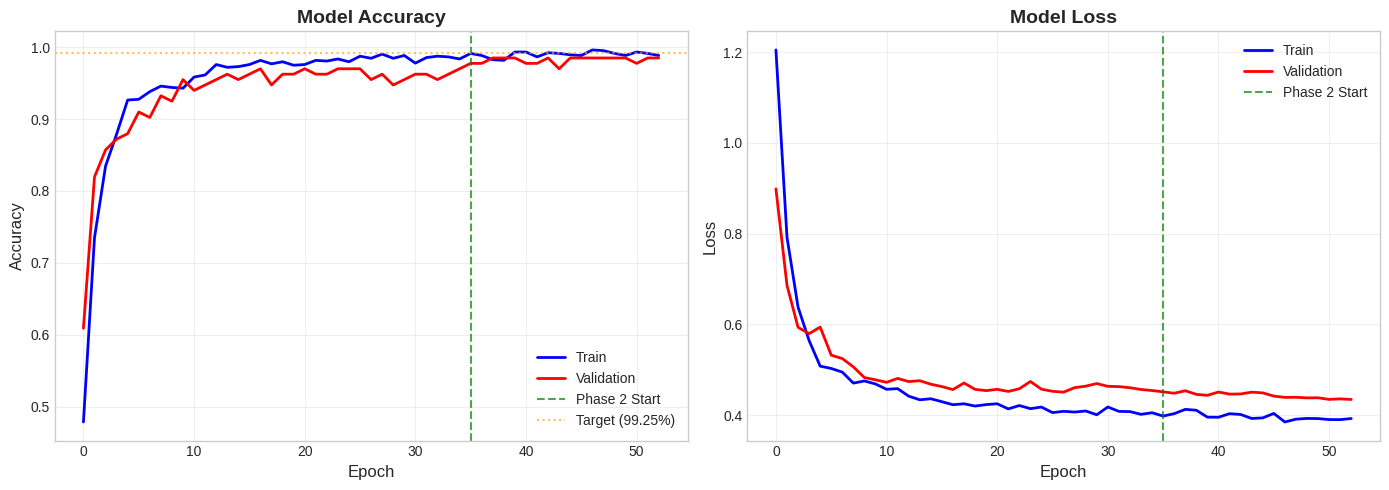

In [10]:
# Training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
phase1_end = len(history_phase1.history['accuracy'])

axes[0].plot(history['accuracy'], 'b-', label='Train', linewidth=2)
axes[0].plot(history['val_accuracy'], 'r-', label='Validation', linewidth=2)
axes[0].axvline(x=phase1_end, color='g', linestyle='--', label='Phase 2 Start', alpha=0.7)
axes[0].axhline(y=0.9925, color='orange', linestyle=':', label='Target (99.25%)', alpha=0.7)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['loss'], 'b-', label='Train', linewidth=2)
axes[1].plot(history['val_loss'], 'r-', label='Validation', linewidth=2)
axes[1].axvline(x=phase1_end, color='g', linestyle='--', label='Phase 2 Start', alpha=0.7)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150)
plt.show()

Giai đoạn 1 Epoch 0-35: Mô hình hội tụ nhanh chóng và đạt độ ổn định ở mức accuracy ~96-97%. Đường Validation bám sát đường Train, chứng tỏ mô hình không bị overfitting (quá khớp).
Giai đoạn 2 Epoch 35+: Sau khi bắt đầu Fine-tuning (đường đứt nét xanh), hiệu suất mô hình tiếp tục được cải thiện nhẹ và duy trì ổn định ở mức rất cao.

In [11]:
# Predictions
val_generator.reset()
y_pred = model.predict(val_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=CLASS_NAMES))

5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step

Classification Report:
                   precision    recall  f1-score   support

          healthy       1.00      1.00      1.00        44
angular_leaf_spot       0.98      0.98      0.98        44
        bean_rust       0.98      0.98      0.98        45

         accuracy                           0.98       133
        macro avg       0.99      0.99      0.99       133
     weighted avg       0.98      0.98      0.98       133



Khả năng nhận diện lớp "Healthy" đạt điểm tuyệt đối Precision, Recall và F1-score đều là 1.00 nghĩa là mô hình không bỏ sót hay nhầm lẫn bất kỳ mẫu lá khỏe mạnh nào.

Hai lớp bệnh "Angular Leaf Spot" và "Bean Rust", các chỉ số cũng rất ấn tượng ở mức 0.98

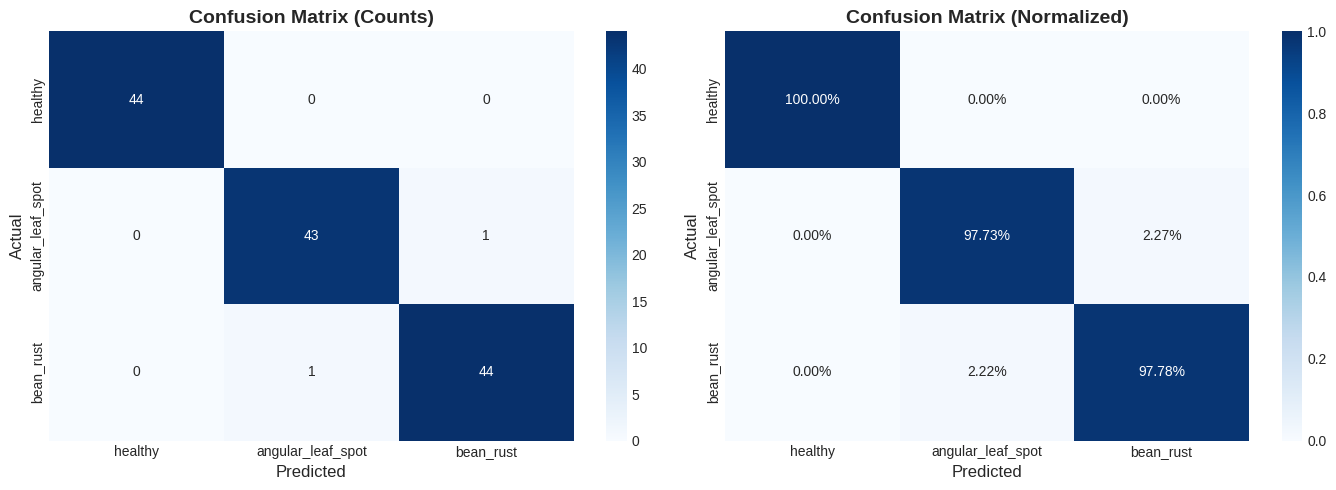

In [12]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('Actual', fontsize=12)

cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues', ax=axes[1],
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_ylabel('Actual', fontsize=12)

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150)
plt.show()

Có 1 mẫu Angular leaf spot bị nhầm thành Bean rust, và ngược lại có 1 mẫu Bean rust bị nhầm thành Angular leaf spot.

## 8. Save Model

In [13]:
import json

model.save('bean_leaf_classifier_final.keras')
print("Model saved to bean_leaf_classifier_final.keras")

with open('training_history.json', 'w') as f:
    json.dump(history, f)
print("Training history saved to training_history.json")

Model saved to bean_leaf_classifier_final.keras
Training history saved to training_history.json


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step 
Số lượng ảnh bị phân loại sai: 2/133
Accuracy: 98.50%

Ảnh sai #1:
   File: angular_leaf_spot_val.20.jpg
   Actual: angular_leaf_spot
   Predicted: bean_rust (55.8%)
   All probabilities:
      healthy: 40.20% 
      angular_leaf_spot: 4.02% CORRECT
      bean_rust: 55.77% WRONG

Ảnh sai #2:
   File: bean_rust_val.38.jpg
   Actual: bean_rust
   Predicted: angular_leaf_spot (59.4%)
   All probabilities:
      healthy: 29.16% 
      angular_leaf_spot: 59.43% WRONG
      bean_rust: 11.41% CORRECT


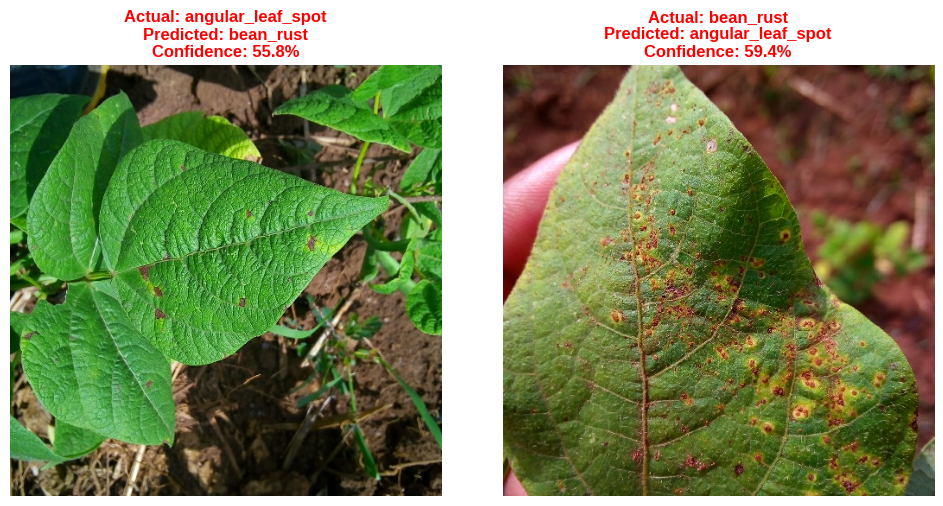

In [14]:
val_generator.reset()
# Lấy predictions
predictions = model.predict(val_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = val_generator.classes
# Lấy tên file và class names
filenames = val_generator.filenames
class_labels = list(val_generator.class_indices.keys())
# Tìm các indices bị phân loại sai
misclassified_indices = np.where(predicted_classes != true_classes)[0]
print(f"Số lượng ảnh bị phân loại sai: {len(misclassified_indices)}/{len(true_classes)}")
print(f"Accuracy: {(1 - len(misclassified_indices)/len(true_classes))*100:.2f}%")
# Hiển thị các ảnh bị sai
fig, axes = plt.subplots(1, len(misclassified_indices), figsize=(5*len(misclassified_indices), 5))
# Nếu chỉ có 1 ảnh sai, axes không phải array
if len(misclassified_indices) == 1:
    axes = [axes]
for idx, wrong_idx in enumerate(misclassified_indices):
    # Đọc ảnh
    img_path = val_df.iloc[wrong_idx]['path_full']
    img = Image.open(img_path)
    
    # Lấy thông tin
    true_label = CLASS_NAMES[true_classes[wrong_idx]]
    pred_label = CLASS_NAMES[predicted_classes[wrong_idx]]
    confidence = predictions[wrong_idx][predicted_classes[wrong_idx]] * 100
    
    # Hiển thị
    axes[idx].imshow(img)
    axes[idx].set_title(
        f"Actual: {true_label}\n"
        f"Predicted: {pred_label}\n"
        f"Confidence: {confidence:.1f}%",
        fontsize=12, color='red', fontweight='bold'
    )
    axes[idx].axis('off')
    # In thông tin chi tiết
    print(f"\nẢnh sai #{idx+1}:")
    print(f"   File: {os.path.basename(img_path)}")
    print(f"   Actual: {true_label}")
    print(f"   Predicted: {pred_label} ({confidence:.1f}%)")
    print(f"   All probabilities:")
    for i, prob in enumerate(predictions[wrong_idx]):
        marker = "WRONG" if i == predicted_classes[wrong_idx] else ("CORRECT" if i == true_classes[wrong_idx] else "")
        print(f"      {CLASS_NAMES[i]}: {prob*100:.2f}% {marker}")
plt.tight_layout()
plt.savefig('misclassified_samples.png', dpi=150, bbox_inches='tight')
plt.show()



Quan sát ảnh, các đốm bệnh khá nhỏ và rải rác, có thể mô hình đã nhầm lẫn các đốm hoại tử nhỏ này với các mụn gỉ sắt

Ảnh thực tế là Bean Rust nhưng bị nhầm là Angular Leaf Spot. Lá cây có mật độ đốm dày đặc với màu nâu đỏ. Có thể do góc chụp hoặc ánh sáng làm các nốt sần gỉ sắt trông phẳng giống như các vết bệnh góc cạnh của Angular Leaf Spot.

In [15]:


from sklearn.model_selection import StratifiedKFold
import gc

# Gộp data
all_df = pd.concat([train_df, val_df], ignore_index=True)
all_df['category_str'] = all_df['category'].astype(str)
print(f"Total samples: {len(all_df)}")

N_FOLDS = 5
fold_results = []
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=CONFIG['SEED'])

for fold, (train_idx, val_idx) in enumerate(skf.split(all_df, all_df['category'])):
    print(f"FOLD {fold + 1}/{N_FOLDS}")
    fold_train_df = all_df.iloc[train_idx].reset_index(drop=True)
    fold_val_df = all_df.iloc[val_idx].reset_index(drop=True)
    
    fold_train_gen = train_datagen.flow_from_dataframe(
        dataframe=fold_train_df, x_col='path_full', y_col='category_str',
        target_size=(CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']),
        batch_size=CONFIG['BATCH_SIZE'], class_mode='categorical',
        shuffle=True, seed=CONFIG['SEED']
    )
    fold_val_gen = val_datagen.flow_from_dataframe(
        dataframe=fold_val_df, x_col='path_full', y_col='category_str',
        target_size=(CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']),
        batch_size=CONFIG['BATCH_SIZE'], class_mode='categorical',
        shuffle=False
    )
    
    tf.keras.backend.clear_session()
    gc.collect()
    model, base_model = build_model(CONFIG['NUM_CLASSES'], freeze_base=True)
    trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])
    total_params = np.sum([np.prod(v.shape) for v in model.weights])
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Non-trainable: {total_params - trainable_params:,}")
    print(f"Base model frozen: {not base_model.trainable}")
    model.compile(
        optimizer=AdamW(learning_rate=CONFIG['PHASE1_LR'], weight_decay=1e-2),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )
    callbacks_phase1 = [
        LearningRateScheduler(warmup_lr_schedule, verbose=1),
        EarlyStopping(
            monitor='val_loss',
            patience=8,
            restore_best_weights=True,
            mode='min',
            verbose=1
        ),
        ModelCheckpoint(
            f'fold{fold+1}_phase1_best.keras',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-7,
            verbose=1
        )
    ]
    print("PHASE 1: Training Classification Head")
    print(f"Learning Rate: {CONFIG['PHASE1_LR']} (with warmup)")
    print(f"Epochs: {CONFIG['PHASE1_EPOCHS']}")
    history_phase1 = model.fit(
        fold_train_gen,
        epochs=CONFIG['PHASE1_EPOCHS'],
        validation_data=fold_val_gen,
        callbacks=callbacks_phase1,
        verbose=1
    )
    print(f"\nPhase 1 Best Val Accuracy: {max(history_phase1.history['val_accuracy']):.4f}")
    print("PHASE 2: Fine-Tuning MobileNetV3Large")
    # Unfreeze the base model
    base_model.trainable = True
    # Freeze first 50 layers
    FINE_TUNE_FROM = 50
    for layer in base_model.layers[:FINE_TUNE_FROM]:
        layer.trainable = False
    # CRITICAL: Freeze BatchNormalization layers
    for layer in base_model.layers:
        if isinstance(layer, layers.BatchNormalization):
            layer.trainable = False
    trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])
    print(f"Trainable parameters after unfreeze: {trainable_params:,}")
    print(f"Layers frozen: {FINE_TUNE_FROM} (+ all BatchNorm layers)")
    # Compile with lower learning rate
    model.compile(
        optimizer=AdamW(learning_rate=CONFIG['PHASE2_LR'], weight_decay=1e-2),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )
    callbacks_phase2 = [
        EarlyStopping(
            monitor='val_accuracy',
            patience=15,
            restore_best_weights=True,
            mode='max',
            verbose=1
        ),
        ModelCheckpoint(
            f'fold{fold+1}_best_model.keras',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        )
    ]
    
    print(f"Learning Rate: {CONFIG['PHASE2_LR']}")
    print(f"Epochs: {CONFIG['PHASE2_EPOCHS']}")
    
    fold_train_gen.reset()
    fold_val_gen.reset()
    
    history_phase2 = model.fit(
        fold_train_gen,
        epochs=CONFIG['PHASE2_EPOCHS'],
        validation_data=fold_val_gen,
        callbacks=callbacks_phase2,
        verbose=1
    )
    
    best_val_acc = max(history_phase2.history['val_accuracy'])
    samples_correct = int(best_val_acc * len(fold_val_df))
    samples_wrong = len(fold_val_df) - samples_correct
    print("PHASE 2 RESULTS")
    print(f"Best Val Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
    print(f"Samples: {samples_correct}/{len(fold_val_df)} correct, {samples_wrong} wrong")
    
    # Lưu kết quả fold
    fold_results.append({
        'fold': fold + 1,
        'phase1_acc': max(history_phase1.history['val_accuracy']),
        'phase2_acc': best_val_acc,
        'samples_correct': samples_correct,
        'samples_wrong': samples_wrong
    })
    
    del model, base_model
    gc.collect()

print("CROSS-VALIDATION SUMMARY")
results_df = pd.DataFrame(fold_results)
print(results_df.to_string(index=False))

mean_acc = results_df['phase2_acc'].mean()
std_acc = results_df['phase2_acc'].std()
print(f"\nFinal Accuracy: {mean_acc*100:.2f}% ± {std_acc*100:.2f}%")
print(f"Best Fold: {results_df.loc[results_df['phase2_acc'].idxmax(), 'fold']} ({results_df['phase2_acc'].max()*100:.2f}%)")

Total samples: 1167
FOLD 1/5
Found 933 validated image filenames belonging to 3 classes.
Found 234 validated image filenames belonging to 3 classes.
Total parameters: 3,244,163
Trainable parameters: 247,299
Non-trainable: 2,996,864
Base model frozen: True
PHASE 1: Training Classification Head
Learning Rate: 0.0005 (with warmup)
Epochs: 50

Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.4034 - loss: 1.2789
Epoch 1: val_accuracy improved from -inf to 0.63248, saving model to fold1_phase1_best.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 36s 870ms/step - accuracy: 0.4064 - loss: 1.2745 - val_accuracy: 0.6325 - val_loss: 0.9593 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0002.
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.6526 - loss: 0.8849
Epoch 2: val_accuracy improved from 0.63248 to 0.77350, saving model to fold1_phase1_best.keras
30/30 ━━━━━━━━━━━━━━━━

2025-12-25 13:59:49.259773: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-25 13:59:49.455699: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 802ms/step - accuracy: 0.9773 - loss: 0.4266
Epoch 1: val_accuracy improved from -inf to 0.94017, saving model to fold1_best_model.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.9772 - loss: 0.4268 - val_accuracy: 0.9402 - val_loss: 0.4969 - learning_rate: 1.0000e-05
Epoch 2/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.9472 - loss: 0.4608
Epoch 2: val_accuracy did not improve from 0.94017
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 450ms/step - accuracy: 0.9478 - loss: 0.4601 - val_accuracy: 0.9316 - val_loss: 0.4943 - learning_rate: 1.0000e-05
Epoch 3/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.9790 - loss: 0.4293
Epoch 3: val_accuracy did not improve from 0.94017
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 450ms/step - accuracy: 0.9790 - loss: 0.4292 - val_accuracy: 0.9359 - val_loss: 0.4945 - learning_rate: 1.0000e-05
Epoch 4/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.9787 - loss: 0.4252
Epoch 4: val_accuracy did not improve 

2025-12-25 14:32:18.236439: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-25 14:32:18.432389: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 818ms/step - accuracy: 0.9773 - loss: 0.4083
Epoch 1: val_accuracy improved from -inf to 0.93991, saving model to fold3_best_model.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.9774 - loss: 0.4083 - val_accuracy: 0.9399 - val_loss: 0.4635 - learning_rate: 1.0000e-05
Epoch 2/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.9813 - loss: 0.4074
Epoch 2: val_accuracy improved from 0.93991 to 0.94421, saving model to fold3_best_model.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 483ms/step - accuracy: 0.9814 - loss: 0.4074 - val_accuracy: 0.9442 - val_loss: 0.4563 - learning_rate: 1.0000e-05
Epoch 3/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.9944 - loss: 0.3943
Epoch 3: val_accuracy did not improve from 0.94421
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 456ms/step - accuracy: 0.9943 - loss: 0.3943 - val_accuracy: 0.9442 - val_loss: 0.4586 - learning_rate: 1.0000e-05
Epoch 4/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.9961 - loss: 0

Mô hình đạt độ chính xác trung bình (Final Accuracy) là 96.83% trên 5 lần thử nghiệm

Độ lệch chuẩn  ± 1.47% chứng tỏ mô hình có tính ổn định cao
Phase 2 (Fine-tuning) luôn giúp cải thiện hoặc duy trì hiệu suất cao đạt được từ Phase 1.

Với độ chính xác trung bình xấp xỉ 97% và độ lệch chuẩn thấp, mô hình MobileNetV3 được tinh chỉnh (fine-tuned) được khẳng định là có khả năng tổng quát hóa tốt

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

model = tf.keras.models.load_model(r'D:\DataMining\DoAnFinal\results\best_model.keras')
CLASS_NAMES = ['healthy', 'angular_leaf_spot', 'bean_rust'] 
img = tf.keras.preprocessing.image.load_img(
    r'D:\DataMining\DoAnFinal\train\angular_leaf_spot\angular_leaf_spot_train.71.jpg', 
    target_size=(224, 224)
)
img_array = np.expand_dims(tf.keras.preprocessing.image.img_to_array(img) / 255.0, axis=0)
pred = model.predict(img_array, verbose=0)[0]
idx = np.argmax(pred)
plt.imshow(img)
plt.title(f'{CLASS_NAMES[idx]} ({pred[idx]*100:.1f}%)')
plt.axis('off')
plt.show()
for name, prob in zip(CLASS_NAMES, pred):
    print(f'{name:20s}: {prob*100:6.2f}%')

: 